In [1]:
import shapeworks as sw
import os
import numpy as np
from glob import glob
import nibabel as nib
from nibabel.testing import data_path
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from skimage.draw import ellipsoid
import meshplot as mp
import igl
import gzip
import shutil
from scipy.spatial.transform import Rotation as R
import trimesh
from tqdm import tqdm
from sdf import *
import SimpleITK as sitk
import vtk
import copy
from contextlib import contextmanager
import sys
from ipywidgets import interact, widgets
import pymeshlab
import pyvista as pv
from tqdm import tqdm
import pandas as pd

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [3]:
def nii_2_mesh (filename_nii, filename_stl, label):

    """
    Read a nifti file including a binary map of a segmented organ with label id = label. 
    Convert it to a smoothed mesh of type stl.
    filename_nii     : Input nifti binary map 
    filename_stl     : Output mesh name in stl format
    label            : segmented label id 
    https://github.com/MahsaShk/MeshProcessing/blob/master/nii_2_mesh_conversion.py
    """

    # read the file
    reader = vtk.vtkNIFTIImageReader()
    reader.SetFileName(filename_nii)
    reader.Update()
    
    # apply marching cube surface generation
    surf = vtk.vtkDiscreteMarchingCubes()
    surf.SetInputConnection(reader.GetOutputPort())
    surf.SetValue(0, label) # use surf.GenerateValues function if more than one contour is available in the file
    surf.Update()
    
    #smoothing the mesh
    smoother= vtk.vtkWindowedSincPolyDataFilter()
    if vtk.VTK_MAJOR_VERSION <= 5:
        smoother.SetInput(surf.GetOutput())
    else:
        smoother.SetInputConnection(surf.GetOutputPort())
    smoother.SetNumberOfIterations(30) 
    smoother.NonManifoldSmoothingOn()
    smoother.NormalizeCoordinatesOn() #The positions can be translated and scaled such that they fit within a range of [-1, 1] prior to the smoothing computation
    smoother.GenerateErrorScalarsOn()
    smoother.Update()
     
    # save the output
    writer = vtk.vtkSTLWriter()
    writer.SetInputConnection(smoother.GetOutputPort())
    writer.SetFileTypeToASCII()
    writer.SetFileName(filename_stl)
    writer.Write()

In [4]:
def nrrd2mesh(nrrd_file_path, output_stl_path):
    "https://discourse.slicer.org/t/converting-nrrd-file-to-stl-using-python/24166/2"
    label = 255

    reader = vtk.vtkNrrdReader()
    reader.SetFileName(nrrd_file_path)
    reader.Update()
    img = read.GetOutput()

    marching_cubes_filter = vtk.vtkDiscreteMarchingCubes()
    marching_cubes_filter.SetInputData(img)
    marching_cubes_filter.SetValue(0, 255)
    marching_cubes_filter.Update()
    polydata = marching_cubes_filter.GetOutput()

    writer = vtk.vtkSTLWriter()
    writer.SetInputData(polydata)
    writer.SetFileName(output_stl_path)
    writer.Write()

In [5]:
def nrrd2nii(filename_nrrd, filename_nii):
    img = sitk.ReadImage("subjects/ab300_070/groomed/standard_DT.nrrd")
    sitk.WriteImage(img, "your_image.nii")
    

## Copy all binary segmentation files into one directory

In [82]:
for segmentation in tqdm(glob("subjects/*/standard.nii")):
    dst = "binary_segmentations/" + segmentation.split("/")[1] + "_" + segmentation.split("/")[-1]
    shutil.copyfile(segmentation, dst)

100%|█████████████████████████████████████████████████████████████████████████████████| 511/511 [03:25<00:00,  2.48it/s]


## Apply ShapeWorks grooming (currently done in ShapeWorks Studio)
- Padding: 10
- Antialias: 10
- Distance Transform
- Blur: Sigma=1,00

In [1]:
# define parameters that controls the plotter
off_screen=None,
full_screen=False,
screenshot=None,
interactive=True,
cpos=None,
window_size=None,
show_bounds=False,
show_axes=True,
notebook=None,
background=None,
text='',
return_img=False,
eye_dome_lighting=False,
volume=False,
parallel_projection=False,
use_ipyvtk=None,
jupyter_backend=None,
return_viewer=False,
jupyter_kwargs={},

In [12]:
seg = sw.Image("binary_segmentations/ab300_001_standard.nii")
print(np.unique(seg.toArray()))
seg_vtk = sw.sw2vtkImage(seg)
seg_vtk.slice(normal='z').plot()

[0. 1. 2.]


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [13]:
seg = seg.binarize(0)
print(np.unique(seg.toArray()))
seg_vtk = sw.sw2vtkImage(seg)
seg_vtk.slice(normal='z').plot()

[0. 1.]


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [204]:
seg = seg.pad(10, 0)
seg_vtk = sw.sw2vtkImage(seg)
seg_vtk.slice(normal='z').plot()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [14]:
seg = seg.computeDT(0)
print(np.unique(seg.toArray()))
seg_vtk = sw.sw2vtkImage(seg)
seg_vtk.slice(normal='z').plot()

[-0.0000000e+00  1.7014117e+38]


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [17]:
seg = seg.gaussianBlur(1)
seg_vtk = sw.sw2vtkImage(seg)
seg_vtk.slice(normal='z').plot()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [98]:
seg.binarize()

{
	dims: [220, 216, 20],
	origin: [-47.3771, -54.954, -44.8817],
	size: [220, 216, 20],
	spacing: [1, 1, 1]
}

In [100]:
seg.computeDT()

{
	dims: [220, 216, 20],
	origin: [-47.3771, -54.954, -44.8817],
	size: [220, 216, 20],
	spacing: [1, 1, 1]
}

In [105]:
seg.gaussianBlur(1)

{
	dims: [220, 216, 20],
	origin: [-47.3771, -54.954, -44.8817],
	size: [220, 216, 20],
	spacing: [1, 1, 1]
}

In [57]:
bb

{
	min: [28.0591, 30.4239, -9.90815],
	max: [98.3362, 82.965, 11.7234]
}

In [67]:
bb = sw.ImageUtils.boundingBox([seg], 1.5)

In [ ]:
segs_bounding_box = sw.ImageUtils.boundingBox(shape_seg_list, iso_value)
shape_seg         = sw.Image(in_shape_filename)

In [68]:
seg = seg.crop(bb, 10)

ValueError: Invalid region specified (it may lie outside physical bounds of image).

In [106]:
# define parameters that controls the plotter
use_same_window = False # plot using multiple rendering windows if false
notebook        = False # True will enable the plots to lie inline
show_borders    = True  # show borders for each rendering window
shade_volumes   = True  # use shading when performing volume rendering
color_map       = "bone" # color map for volume rendering, e.g., 'bone', 'coolwarm', 'cool', 'viridis', 'magma'
show_axes       = True  # show a vtk axes widget for each rendering window
show_bounds     = True  # show volume bounding box
show_all_edges  = True  # add an unlabeled and unticked box at the boundaries of plot. 
font_size       = 10    # text font size for windows
link_views      = True  # link all rendering windows so that they share same camera and axes boundaries

# plot all segmentations in the shape list
sw.plot_volumes([seg],    
             #volumeNames     = shapeNames, 
             use_same_window = use_same_window,
             notebook        = notebook,
             show_borders    = show_borders,  
             shade_volumes   = shade_volumes, 
             color_map       = color_map,
             show_axes       = show_axes,  
             show_bounds     = True,
             show_all_edges  = show_all_edges, 
             font_size       = font_size,   
             link_views      = link_views
             )

In [4]:
shapeSeg_vtk = sw.sw2vtkImage(seg)

In [5]:
import pyvista as pv

notebook = False # True will bring the renderings inline
# click r to reset the view after zooming
shapeSeg_vtk.plot(volume     = True,     # volume render
                  shade      = True,
                  notebook = notebook,
                  show_bounds=True)     # enable shading

[(7.2474084086859625, 197.3816356709508, 339.612200362855),
 (62.12286376953125, 52.545982360839844, -35.38167953491211),
 (-0.46010076522453935, -0.848790688944597, 0.26050269135030113)]

In [ ]:
notebook = False # True will bring the renderings inline
# click r to reset the view after zooming
sw.plot_volumes(seg,
                notebook = notebook, 
                show_borders   = show_borders,  
                shade_volumes  = shade_volumes,  
                show_axes      = show_axes,  
                show_bounds    = show_bounds,
                show_all_edges = show_all_edges, 
                font_size      = font_size,   
                link_views     = True )     # enable shading

In [6]:
seg.pad(10, 0)

{
	dims: [240, 236, 40],
	origin: [-47.3771, -54.954, -44.8817],
	size: [240, 236, 40],
	spacing: [1, 1, 1]
}

In [83]:
shapeSeg2_vtk = sw.sw2vtkImage(seg)

In [84]:
shapeSeg2_vtk

UniformGrid (0x1a5315825e8)
  N Cells:	894615
  N Points:	950400
  X Bounds:	-4.738e+01, 1.716e+02
  Y Bounds:	-5.495e+01, 1.600e+02
  Z Bounds:	-4.488e+01, -2.588e+01
  Dimensions:	220, 216, 20
  Spacing:	1.000e+00, 1.000e+00, 1.000e+00
  N Arrays:	1

In [19]:
mesh_dict = {}

for i, segmentation in tqdm(enumerate(glob("binary_segmentations\\*.nii"))):
    
    # Extract filename
    filename = segmentation.split("\\")[-1].split(".")[0]
    
    # Read binary segmentation file
    shape_seg = sw.Image(segmentation)
    
    # Binarize image
    shape_seg.binarize(0)
    
    # Padding
    shape_seg.pad(5, 0)
    
    # Compute distance transform
    shape_seg.computeDT(0)
    
    # Reduce high-frequency information 
    shape_seg.gaussianBlur(0.05)
    
    # Convert into mesh
    mesh_shape = shape_seg.toMesh(1)
    
    # Smooth mesh surface
    mesh_shape.smooth(3, 1)
    
    # Center mesh
    center = mesh_shape.center()
    mesh_shape.translate(list(-center))
    
    # Scale mesh
    bb = mesh_shape.boundingBox()
    bb.max.max() - bb.min.min()
    scale_factor = 1 / (bb.max.max() - bb.min.min())
    mesh_shape = mesh_shape.scale([scale_factor, scale_factor, scale_factor])
    
    # Append mesh to list
    mesh_dict[filename] = mesh_shape    
    
    mesh_shape.write(f"binary_segmentations\\groomed\\{filename}.ply")
    

# Find reference medoid shape
mesh_list = list(mesh_dict.values())
ref_index = sw.find_reference_mesh_index(mesh_list)
ref_mesh = mesh_list[ref_index]

# Align all meshes to the reference medoid shape
for name, mesh in tqdm(mesh_dict.items()):
    # compute rigid transformation
    rigid_transform = mesh.createTransform(ref_mesh, sw.Mesh.AlignmentType.Rigid, 100)
    # apply rigid transform
    mesh.applyTransform(rigid_transform)
    mesh.write(f"binary_segmentations\\aligned\\{name}.ply")

511it [10:16,  1.21s/it]
100%|████████████████████████████████████████████████████████████████████████████████| 511/511 [02:25<00:00,  3.51it/s]


In [26]:
for mesh_path in tqdm(glob("binary_segmentations\\aligned\\*.ply")):
    filename = mesh_path.split("\\")[-1].split(".")[0]
    mesh = pv.read(mesh_path)
    mesh.save(f"binary_segmentations\\aligned_vtk\\{filename}.vtk")

100%|████████████████████████████████████████████████████████████████████████████████| 511/511 [00:39<00:00, 12.92it/s]


In [13]:
for mesh_path in tqdm(glob("binary_segmentations\\registrated_vtk\\*.vtk")):
    filename = mesh_path.split("\\")[-1].split(".")[0]
    mesh = pv.read(mesh_path)
    mesh.save(f"binary_segmentations\\registrated\\{filename}.ply")

100%|████████████████████████████████████████████████████████████████████████████████| 511/511 [01:25<00:00,  6.01it/s]


In [3]:
original_meshes = glob("binary_segmentations\\aligned\\*.ply")
reconstr_meshes = glob("binary_segmentations\\registrated\\*.ply")

100%|████████████████████████████████████████████████████████████████████████████████| 511/511 [00:44<00:00, 11.41it/s]


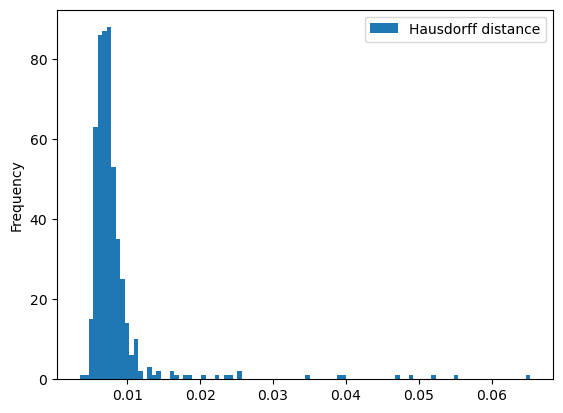

In [13]:
distances = []

for i in tqdm(range(len(original_meshes))):
    
    mesh_o = o3d.io.read_triangle_mesh(original_meshes[i])
    vertices_o = np.asarray(mesh_o.vertices)
    faces_o = np.asarray(mesh_o.triangles)
    
    mesh_r = o3d.io.read_triangle_mesh(reconstr_meshes[i])    
    vertices_r = np.asarray(mesh_r.vertices)
    faces_r = np.asarray(mesh_r.triangles)
    
    distances.append(igl.hausdorff(vertices_o, faces_o, vertices_r, faces_r))

df = pd.DataFrame(distances, columns=["Hausdorff distance"])
df.plot.hist(bins=100)

In [1]:
ref_index

NameError: name 'ref_index' is not defined

In [23]:
list(mesh_dict.keys())[262]

'ab300_283_standard'

In [9]:
vertices1, faces1 = igl.read_triangle_mesh("binary_segmentations/aligned/ab300_002_standard.ply")

In [10]:
vertices2, faces2 = igl.read_triangle_mesh("ab300_001_recon.ply")

In [12]:
igl.hausdorff(vertices1, faces1, vertices1, faces1)

0.0

In [6]:
mesh = pv.read("../../../../output_tiny/DeterministicAtlas__Reconstruction__hippo__subject_ab300_001_standard.vtk")
mesh.save(f"ab300_001_recon.ply")

In [20]:
print("Ende")

Ende


In [76]:
ref_index

3

In [66]:
bb = mesh_list[0].boundingBox()

In [67]:
scale_factor = 1 / (bb.max.max() - bb.min.min())

In [70]:
scale_factor

0.013525294582395746

In [71]:
mesh_list[0].scale([scale_factor, scale_factor, scale_factor])

{
number of points: 5676,
number of faces: 11344,
center: [-0.00961751, 0.0143897, 0.000715557],
center or mass: [-0.00246601, -0.0114887, -0.0111386],
bounding box: {
	min: [-0.509618, -0.367544, -0.105231],
	max: [0.490382, 0.396323, 0.106662]
},
field names: 
	Normals
	scalars

In [46]:
center = mesh_list[0].center()

-center

test = mesh_list[0].translate(list(-center))

In [49]:
test

{
number of points: 5676,
number of faces: 11344,
center: [0, 0, 0],
center or mass: [0.529533, -1.91212, -0.876327],
bounding box: {
	min: [-36.9695, -28.2473, -7.83492],
	max: [36.9695, 28.2473, 7.83492]
},
field names: 
	Normals
	scalars

In [55]:
shape_mesh = sw.sw2vtkImage(shape_seg)

In [56]:
shape_mesh

UniformGrid (0x1fe59a1cb28)
  N Cells:	894615
  N Points:	950400
  X Bounds:	-4.550e+01, 1.735e+02
  Y Bounds:	-5.194e+01, 1.631e+02
  Z Bounds:	-2.039e+01, -1.391e+00
  Dimensions:	220, 216, 20
  Spacing:	1.000e+00, 1.000e+00, 1.000e+00
  N Arrays:	1

In [47]:
for mesh in tqdm(glob("binary_segmentations\\*.nii")):
    shape_seg = sw.Image(mesh)
    shape_seg.gaussianBlur(0.2)
    shape_mesh = shape_seg.toMesh()
#     filename = mesh.split("\\")[-1].split(".")[0] + "_smoothed.ply"
#     shape_mesh = sw.Mesh(mesh)
#     shape_mesh.smooth(3, 1)
#     shape_mesh.fillHoles()
#     shape_mesh.write(f"raw_meshes\\{filename}")


  0%|                                                                                                      | 0/511 [00:00<?, ?it/s]


TypeError: toMesh(): incompatible function arguments. The following argument types are supported:
    1. (self: shapeworks_py.Image, isovalue: float) -> shapeworks::Mesh

Invoked with: {
	dims: [220, 216, 20],
	origin: [-47.3771, -54.954, -44.8817],
	size: [220, 216, 20],
	spacing: [1, 1, 1]
}

## Convert groomed .nrrd files into .nii format

In [42]:
for segmentation in tqdm(glob("binary_segmentations/groomed/*.nrrd")):
    filename = segmentation.split("/")[-1].split(".")[0] + ".nii"
    img = sitk.ReadImage(segmentation)
    sitk.WriteImage(img, f"binary_segmentations/groomed/{filename}")

100%|█████████████████████████████████████████████████████████████████████████████████| 511/511 [07:34<00:00,  1.12it/s]


## Convert volumetric shapes into meshes

In [43]:
for segmentation in tqdm(glob("binary_segmentations/groomed/*.nii")):
    filename = segmentation.split("/")[-1].split(".")[0] + ".ply"
    img = nib.load(segmentation)
    data = img.get_fdata()
    verts, faces, normals, values = measure.marching_cubes(data, 0)
    igl.write_triangle_mesh(f"binary_segmentations/groomed/{filename}", verts, faces)

100%|█████████████████████████████████████████████████████████████████████████████████| 511/511 [10:48<00:00,  1.27s/it]


In [14]:
shape_list = glob("binary_segmentations/groomed/*standard_DT.ply")

@interact(i=widgets.IntSlider(min=0, max=len(shape_list)-1, step=1))
def visualize(i):
    print(shape_list[i].split("/")[-1])
    vertices, faces = igl.read_triangle_mesh(shape_list[i])
    mp.plot(vertices, faces)

interactive(children=(IntSlider(value=0, description='i', max=510), Output()), _dom_classes=('widget-interact'…

## MOI Alignment

#vertices, faces = igl.read_triangle_mesh(shape_list[0])

ms = pymeshlab.MeshSet()
ms.load_new_mesh(shape_list[0])
ms.compute_matrix_by_principal_axis()
face_matrix = ms.current_mesh().face_matrix()
vertex_matrix = ms.current_mesh().vertex_matrix()
faces_aligned = np.array(face_matrix)
vertices_aligned = np.array(vertex_matrix)
mp.plot(vertices_aligned, faces_aligned)

## Cleaning

In [61]:
for mesh in tqdm(glob("binary_segmentations/groomed/*standard_DT.ply")):
    with suppress_stdout():
        filename = mesh.split("/")[-1].split(".")[0] + "_cleaned.ply"
        mesh = o3d.io.read_triangle_mesh(mesh)
        #mp.plot(np.asarray(mesh.vertices), np.asarray(mesh.triangles))
        #print("Clustering connected triangles ...")
        with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:        
            triangle_clusters, cluster_n_triangles, cluster_area = (mesh.cluster_connected_triangles())

        triangle_clusters = np.asarray(triangle_clusters)
        cluster_n_triangles = np.asarray(cluster_n_triangles)
        cluster_area = np.asarray(cluster_area)

        #print("Displaying mesh with small clusters removed ...")
        mesh_0 = copy.deepcopy(mesh)
        triangles_to_remove = cluster_n_triangles[triangle_clusters] < 1000
        mesh_0.remove_triangles_by_mask(triangles_to_remove)
        o3d.io.write_triangle_mesh(f"binary_segmentations/groomed/{filename}", mesh_0)
        #o3d.visualization.draw([mesh_0])
        #mp.plot(np.asarray(mesh_0.vertices), np.asarray(mesh_0.triangles))

100%|█████████████████████████████████████████████████████████████████████████████████| 511/511 [01:03<00:00,  7.99it/s]


In [62]:
shape_list = glob("binary_segmentations/groomed/*cleaned.ply")

@interact(i=widgets.IntSlider(min=0, max=len(shape_list)-1, step=1))
def visualize(i):
    print(shape_list[i].split("/")[-1])
    vertices, faces = igl.read_triangle_mesh(shape_list[i])
    mp.plot(vertices, faces)

interactive(children=(IntSlider(value=0, description='i', max=509), Output()), _dom_classes=('widget-interact'…

## Surface smoothing

In [64]:
for mesh in tqdm(glob("binary_segmentations/groomed/*cleaned.ply")):
    filename = mesh.split("/")[-1].split(".")[0] + "_smoothed.ply"
    mesh = o3d.io.read_triangle_mesh(mesh)
    mesh_out = mesh.filter_smooth_taubin(number_of_iterations=5)
    mesh_out.compute_vertex_normals()
    o3d.io.write_triangle_mesh(f"binary_segmentations/groomed/{filename}", mesh_out)
    #mp.plot(np.asarray(mesh_out.vertices), np.asarray(mesh_out.triangles))

100%|█████████████████████████████████████████████████████████████████████████████████| 510/510 [00:59<00:00,  8.58it/s]


In [32]:
glob("raw_meshes/*.ply")[0].split("\\")

['raw_meshes', 'ab300_001.ply']

In [36]:
for mesh in tqdm(glob("raw_meshes\\*.ply")):
    filename = mesh.split("\\")[-1].split(".")[0] + "_smoothed.ply"
    mesh = o3d.io.read_triangle_mesh(mesh)
    mesh_out = mesh.filter_smooth_laplacian(number_of_iterations=3)
    mesh_out.compute_vertex_normals()
    o3d.io.write_triangle_mesh(f"raw_meshes\\{filename}", mesh_out)
    #mp.plot(np.asarray(mesh_out.vertices), np.asarray(mesh_out.triangles))

100%|████████████████████████████████████████████████████████████████████████████████████████████| 511/511 [00:18<00:00, 28.04it/s]


In [37]:
shape_list = glob("binary_segmentations/groomed/*smoothed.ply")

@interact(i=widgets.IntSlider(min=0, max=len(shape_list)-1, step=1))
def visualize(i):
    print(shape_list[i].split("/")[-1])
    vertices, faces = igl.read_triangle_mesh(shape_list[i])
    mp.plot(vertices, faces)

interactive(children=(IntSlider(value=0, description='i', max=509), Output()), _dom_classes=('widget-interact'…

In [74]:
img = sitk.ReadImage("subjects/ab300_070/groomed/standard_DT.nrrd")
sitk.WriteImage(img, "your_image.nii")

In [75]:
img = nib.load("your_image.nii")

In [76]:
data = img.get_fdata()
verts, faces, normals, values = measure.marching_cubes(data, 0)
igl.write_triangle_mesh("test.ply", verts, faces) 

True

In [77]:
mp.plot(verts, faces)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(115.76505…

In [78]:
mesh = o3d.io.read_triangle_mesh("test.ply")
mesh_out = mesh.filter_smooth_taubin(number_of_iterations=5)
mesh_out.compute_vertex_normals()
mp.plot(np.asarray(mesh_out.vertices), np.asarray(mesh_out.triangles))

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(115.75954…

## 1. Unzip data

In [33]:
for subject in glob("subjects/*/standard.nii.gz"):
    new_file = subject.split(".")[0] + ".nii"
    with gzip.open(subject, 'rb') as f_in:
        with open(new_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

## 2. Convert into mesh representation - Marching Cubes Algorithm

In [35]:
for subject in glob("subjects/*/standard.nii"):
    name = subject.split("/")[1]
    
    img = nib.load(subject)
    data = img.get_fdata()
    verts, faces, normals, values = measure.marching_cubes(data, 0)
    igl.write_triangle_mesh(f"raw_meshes/{name}.ply", verts, faces)

## 3. Surface Smoothing

In [ ]:

mesh = sw.Mesh(in_mesh_filename)
mesh.smooth(iterations, relaxation)


In [52]:
# Laplacian filter

for subject in tqdm(glob("raw_meshes/*.ply")):
    name = subject.split("/")[-1]
    mesh = o3d.io.read_triangle_mesh(subject)
    mesh_out = mesh.filter_smooth_laplacian(number_of_iterations=3)
    mesh_out.compute_vertex_normals()
    o3d.io.write_triangle_mesh(f"raw_meshes_smoothed/{name}", mesh_out)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 511/511 [00:43<00:00, 11.63it/s]


In [53]:
# Taubin filter

for subject in tqdm(glob("raw_meshes/*.ply")):
    name = subject.split("/")[-1]
    mesh = o3d.io.read_triangle_mesh(subject)
    mesh_out = mesh.filter_smooth_taubin(number_of_iterations=5)
    mesh_out.compute_vertex_normals()
    o3d.io.write_triangle_mesh(f"raw_meshes_smoothed/{name}", mesh_out)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 511/511 [00:48<00:00, 10.46it/s]


## 4. Procrustes Superimposition

### 4.1 Center meshes (Tranlation)

In [56]:
for subject in glob("raw_meshes/*.ply"):
    name = subject.split("/")[-1]

    vertices, faces = igl.read_triangle_mesh(subject)

    x_mean = np.mean(vertices[:,0])
    y_mean = np.mean(vertices[:,1])
    z_mean = np.mean(vertices[:,2])

    x_new = vertices[:,0] - x_mean
    y_new = vertices[:,1] - y_mean
    z_new = vertices[:,2] - z_mean

    vertices_new = np.stack([x_new, y_new, z_new], axis=1)
    igl.write_triangle_mesh(f"raw_meshes_centered/{name}", vertices_new, faces)

### 4.2. Uniform Scaling

In [8]:
for subject in tqdm(glob("raw_meshes_centered/*.ply")):
    name = subject.split("/")[-1]
    mesh = o3d.io.read_triangle_mesh(subject)
    scale_factor = 1 / np.max(mesh.get_max_bound() - mesh.get_min_bound())
    mesh.scale(scale_factor, center=mesh.get_center())
    o3d.io.write_triangle_mesh(f"raw_meshes_centered_scaled/{name}", mesh)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 511/511 [00:26<00:00, 19.26it/s]


### 4.3 Align meshes (Rotation) - Kabsch Algorithm

In [48]:
template_mesh = o3d.io.read_triangle_mesh("raw_meshes_centered_scaled/cbbrain_011.ply")
#template_pcd = template_mesh.sample_points_poisson_disk(number_of_points=1000, init_factor=5)
template_pcd = template_mesh.sample_points_uniformly(number_of_points=1000)
#o3d.visualization.draw_geometries([template_pcd])

In [50]:
for subject in tqdm(glob("raw_meshes_centered_scaled/*.ply")):
    name = subject.split("/")[-1]
    mesh = o3d.io.read_triangle_mesh(subject)
    vertices = np.asarray(mesh.vertices)
    faces = np.asarray(mesh.triangles)
    #pcd = mesh.sample_points_poisson_disk(number_of_points=1000, init_factor=5)
    pcd = mesh.sample_points_uniformly(number_of_points=1000)
    #rotation = R.align_vectors(np.asarray(pcd.points), np.asarray(template_pcd.points))
    #r_matrix = rotation[0].as_matrix()
    #vertices = np.matmul(vertices, r_matrix)
    s, R, t = rigid_transform_3D(np.asarray(template_pcd.points), np.asarray(pcd.points), 0)
    vertices = vertices@R
    igl.write_triangle_mesh(f"raw_meshes_centered_scaled_aligned/{name}", vertices, faces)

  1%|▋                                                                                              | 4/511 [00:00<00:14, 33.91it/s]

Reflection detected
Reflection detected
Reflection detected
Reflection detected
Reflection detected


  2%|██▏                                                                                           | 12/511 [00:00<00:13, 37.49it/s]

Reflection detected
Reflection detected
Reflection detected
Reflection detected
Reflection detected
Reflection detected
Reflection detected


  4%|███▊                                                                                          | 21/511 [00:00<00:13, 35.09it/s]

Reflection detected
Reflection detected
Reflection detected
Reflection detected


  6%|█████▎                                                                                        | 29/511 [00:00<00:14, 33.30it/s]

Reflection detected
Reflection detected
Reflection detected
Reflection detected
Reflection detected
Reflection detected


  7%|██████▊                                                                                       | 37/511 [00:01<00:16, 28.73it/s]

Reflection detected
Reflection detected
Reflection detected
Reflection detected


  8%|███████▉                                                                                      | 43/511 [00:01<00:19, 23.59it/s]

Reflection detected
Reflection detected


  9%|████████▍                                                                                     | 46/511 [00:01<00:29, 15.74it/s]

Reflection detected
Reflection detected


  9%|████████▊                                                                                     | 48/511 [00:01<00:30, 15.21it/s]

Reflection detected
Reflection detected
Reflection detected


 11%|█████████▉                                                                                    | 54/511 [00:02<00:28, 16.08it/s]

Reflection detected
Reflection detected
Reflection detected
Reflection detected


 12%|███████████▏                                                                                  | 61/511 [00:02<00:25, 17.49it/s]

Reflection detected


 13%|███████████▉                                                                                  | 65/511 [00:02<00:28, 15.88it/s]

Reflection detected
Reflection detected
Reflection detected


 13%|████████████▎                                                                                 | 67/511 [00:03<00:32, 13.84it/s]

Reflection detected
Reflection detected
Reflection detected


 14%|████████████▋                                                                                 | 69/511 [00:03<00:42, 10.37it/s]

Reflection detected


 14%|█████████████▍                                                                                | 73/511 [00:05<02:14,  3.25it/s]

Reflection detected
Reflection detected


 15%|█████████████▊                                                                                | 75/511 [00:05<01:40,  4.33it/s]

Reflection detected
Reflection detected
Reflection detected


 16%|███████████████                                                                               | 82/511 [00:06<00:45,  9.51it/s]

Reflection detected
Reflection detected


 17%|███████████████▊                                                                              | 86/511 [00:06<00:38, 11.16it/s]

Reflection detected
Reflection detected
Reflection detected


 17%|████████████████▏                                                                             | 88/511 [00:06<00:37, 11.15it/s]

Reflection detected


 18%|█████████████████▎                                                                            | 94/511 [00:07<00:32, 12.81it/s]

Reflection detected
Reflection detected
Reflection detected


 20%|██████████████████▏                                                                          | 100/511 [00:07<00:29, 13.95it/s]

Reflection detected


 20%|██████████████████▌                                                                          | 102/511 [00:07<00:28, 14.14it/s]

Reflection detected
Reflection detected


 21%|███████████████████▋                                                                         | 108/511 [00:08<00:32, 12.57it/s]

Reflection detected
Reflection detected


 22%|████████████████████                                                                         | 110/511 [00:08<00:30, 13.12it/s]

Reflection detected


 23%|█████████████████████                                                                        | 116/511 [00:08<00:25, 15.68it/s]

Reflection detected
Reflection detected


 23%|█████████████████████▊                                                                       | 120/511 [00:09<00:23, 16.33it/s]

Reflection detected
Reflection detected


 24%|██████████████████████▌                                                                      | 124/511 [00:09<00:23, 16.78it/s]

Reflection detected


 25%|███████████████████████▋                                                                     | 130/511 [00:09<00:22, 16.87it/s]

Reflection detected
Reflection detected


 26%|████████████████████████▌                                                                    | 135/511 [00:10<00:31, 12.10it/s]

Reflection detected


 27%|████████████████████████▉                                                                    | 137/511 [00:10<00:56,  6.58it/s]

Reflection detected


 27%|█████████████████████████▎                                                                   | 139/511 [00:11<00:48,  7.72it/s]

Reflection detected
Reflection detected


 28%|██████████████████████████                                                                   | 143/511 [00:11<00:35, 10.32it/s]

Reflection detected
Reflection detected
Reflection detected


 29%|███████████████████████████                                                                  | 149/511 [00:11<00:26, 13.46it/s]

Reflection detected
Reflection detected


 30%|███████████████████████████▊                                                                 | 153/511 [00:11<00:23, 15.08it/s]

Reflection detected


 31%|████████████████████████████▉                                                                | 159/511 [00:12<00:24, 14.15it/s]

Reflection detected
Reflection detected


 32%|█████████████████████████████▋                                                               | 163/511 [00:12<00:23, 14.57it/s]

Reflection detected


 32%|██████████████████████████████                                                               | 165/511 [00:12<00:34,  9.97it/s]

Reflection detected


 33%|██████████████████████████████▊                                                              | 169/511 [00:14<01:01,  5.58it/s]

Reflection detected


 34%|███████████████████████████████▍                                                             | 173/511 [00:14<00:40,  8.42it/s]

Reflection detected
Reflection detected


 34%|███████████████████████████████▊                                                             | 175/511 [00:14<00:34,  9.69it/s]

Reflection detected
Reflection detected


 35%|████████████████████████████████▌                                                            | 179/511 [00:14<00:30, 10.88it/s]

Reflection detected
Reflection detected
Reflection detected


 36%|█████████████████████████████████▎                                                           | 183/511 [00:16<01:00,  5.39it/s]

Reflection detected
Reflection detected


 37%|██████████████████████████████████                                                           | 187/511 [00:16<00:40,  8.08it/s]

Reflection detected


 38%|███████████████████████████████████▏                                                         | 193/511 [00:16<00:27, 11.64it/s]

Reflection detected
Reflection detected
Reflection detected


 38%|███████████████████████████████████▍                                                         | 195/511 [00:16<00:26, 11.90it/s]

Reflection detected
Reflection detected


 39%|████████████████████████████████████▌                                                        | 201/511 [00:17<00:26, 11.79it/s]

Reflection detected
Reflection detected


 40%|█████████████████████████████████████▎                                                       | 205/511 [00:17<00:25, 12.11it/s]

Reflection detected
Reflection detected


 41%|█████████████████████████████████████▋                                                       | 207/511 [00:17<00:23, 12.95it/s]

Reflection detected
Reflection detected


 41%|██████████████████████████████████████▍                                                      | 211/511 [00:18<00:25, 11.91it/s]

Reflection detected


 42%|██████████████████████████████████████▊                                                      | 213/511 [00:18<00:24, 12.02it/s]

Reflection detected
Reflection detected


 42%|███████████████████████████████████████▍                                                     | 217/511 [00:18<00:22, 13.10it/s]

Reflection detected
Reflection detected
Reflection detected
Reflection detected


 44%|█████████████████████████████████████████▎                                                   | 227/511 [00:19<00:17, 16.58it/s]

Reflection detected
Reflection detected


 46%|██████████████████████████████████████████▍                                                  | 233/511 [00:19<00:16, 17.20it/s]

Reflection detected
Reflection detected
Reflection detected


 46%|███████████████████████████████████████████▏                                                 | 237/511 [00:19<00:15, 17.74it/s]

Reflection detected
Reflection detected
Reflection detected


 47%|███████████████████████████████████████████▍                                                 | 239/511 [00:20<00:15, 17.17it/s]

Reflection detected
Reflection detected


 47%|███████████████████████████████████████████▊                                                 | 241/511 [00:20<00:26, 10.03it/s]

Reflection detected
Reflection detected


 48%|████████████████████████████████████████████▏                                                | 243/511 [00:20<00:33,  8.04it/s]

Reflection detected
Reflection detected


 48%|████████████████████████████████████████████▉                                                | 247/511 [00:21<00:26, 10.02it/s]

Reflection detected
Reflection detected


 49%|█████████████████████████████████████████████▋                                               | 251/511 [00:21<00:21, 12.31it/s]

Reflection detected
Reflection detected


 50%|██████████████████████████████████████████████▍                                              | 255/511 [00:21<00:17, 14.54it/s]

Reflection detected
Reflection detected
Reflection detected


 50%|██████████████████████████████████████████████▊                                              | 257/511 [00:22<00:29,  8.65it/s]

Reflection detected


 51%|███████████████████████████████████████████████▊                                             | 263/511 [00:22<00:28,  8.59it/s]

Reflection detected


 52%|████████████████████████████████████████████████▏                                            | 265/511 [00:22<00:24,  9.99it/s]

Reflection detected
Reflection detected
Reflection detected


 54%|██████████████████████████████████████████████████                                           | 275/511 [00:23<00:17, 13.41it/s]

Reflection detected
Reflection detected


 55%|███████████████████████████████████████████████████▏                                         | 281/511 [00:24<00:14, 15.84it/s]

Reflection detected
Reflection detected
Reflection detected
Reflection detected


 55%|███████████████████████████████████████████████████▌                                         | 283/511 [00:24<00:14, 15.46it/s]

Reflection detected


 57%|████████████████████████████████████████████████████▌                                        | 289/511 [00:25<00:28,  7.91it/s]

Reflection detected
Reflection detected


 57%|█████████████████████████████████████████████████████▎                                       | 293/511 [00:25<00:21, 10.12it/s]

Reflection detected
Reflection detected


 58%|██████████████████████████████████████████████████████                                       | 297/511 [00:25<00:17, 11.99it/s]

Reflection detected
Reflection detected


 59%|███████████████████████████████████████████████████████▏                                     | 303/511 [00:26<00:13, 15.26it/s]

Reflection detected
Reflection detected


 60%|███████████████████████████████████████████████████████▌                                     | 305/511 [00:26<00:12, 16.05it/s]

Reflection detected
Reflection detected
Reflection detected


 60%|████████████████████████████████████████████████████████▏                                    | 309/511 [00:26<00:12, 16.09it/s]

Reflection detected
Reflection detected


 61%|████████████████████████████████████████████████████████▌                                    | 311/511 [00:26<00:18, 10.71it/s]

Reflection detected
Reflection detected


 62%|██████████████████████████████████████████████████████████                                   | 319/511 [00:27<00:19,  9.71it/s]

Reflection detected
Reflection detected


 63%|██████████████████████████████████████████████████████████▊                                  | 323/511 [00:28<00:16, 11.53it/s]

Reflection detected
Reflection detected
Reflection detected


 64%|███████████████████████████████████████████████████████████▏                                 | 325/511 [00:28<00:15, 11.79it/s]

Reflection detected
Reflection detected
Reflection detected


 64%|███████████████████████████████████████████████████████████▉                                 | 329/511 [00:28<00:14, 12.44it/s]

Reflection detected
Reflection detected
Reflection detected


 66%|████████████████████████████████████████████████████████████▉                                | 335/511 [00:29<00:11, 15.11it/s]

Reflection detected
Reflection detected
Reflection detected
Reflection detected


 66%|█████████████████████████████████████████████████████████████▋                               | 339/511 [00:29<00:11, 15.34it/s]

Reflection detected
Reflection detected


 68%|██████████████████████████████████████████████████████████████▊                              | 345/511 [00:29<00:11, 14.89it/s]

Reflection detected
Reflection detected
Reflection detected


 68%|███████████████████████████████████████████████████████████████▏                             | 347/511 [00:29<00:12, 13.60it/s]

Reflection detected
Reflection detected


 69%|████████████████████████████████████████████████████████████████▍                            | 354/511 [00:30<00:09, 16.75it/s]

Reflection detected
Reflection detected


 70%|█████████████████████████████████████████████████████████████████▏                           | 358/511 [00:31<00:23,  6.43it/s]

Reflection detected


 72%|███████████████████████████████████████████████████████████████████▏                         | 369/511 [00:31<00:09, 14.29it/s]

Reflection detected
Reflection detected


 75%|█████████████████████████████████████████████████████████████████████▋                       | 383/511 [00:32<00:08, 15.88it/s]

Reflection detected
Reflection detected
Reflection detected


 76%|██████████████████████████████████████████████████████████████████████▍                      | 387/511 [00:32<00:07, 16.07it/s]

Reflection detected


 77%|███████████████████████████████████████████████████████████████████████▌                     | 393/511 [00:34<00:13,  8.73it/s]

Reflection detected
Reflection detected


 78%|████████████████████████████████████████████████████████████████████████▌                    | 399/511 [00:34<00:08, 13.35it/s]

Reflection detected
Reflection detected


 79%|█████████████████████████████████████████████████████████████████████████▎                   | 403/511 [00:34<00:07, 15.03it/s]

Reflection detected


 80%|██████████████████████████████████████████████████████████████████████████                   | 407/511 [00:34<00:06, 16.79it/s]

Reflection detected
Reflection detected
Reflection detected
Reflection detected


 81%|██████████████████████████████████████████████████████████████████████████▉                  | 412/511 [00:34<00:05, 18.65it/s]

Reflection detected
Reflection detected
Reflection detected


 82%|███████████████████████████████████████████████████████████████████████████▉                 | 417/511 [00:35<00:05, 18.06it/s]

Reflection detected


 82%|████████████████████████████████████████████████████████████████████████████▌                | 421/511 [00:36<00:12,  7.19it/s]

Reflection detected
Reflection detected


 84%|█████████████████████████████████████████████████████████████████████████████▋               | 427/511 [00:36<00:07, 11.67it/s]

Reflection detected
Reflection detected
Reflection detected
Reflection detected


 85%|██████████████████████████████████████████████████████████████████████████████▌              | 432/511 [00:36<00:05, 14.76it/s]

Reflection detected
Reflection detected
Reflection detected
Reflection detected


 86%|███████████████████████████████████████████████████████████████████████████████▋             | 438/511 [00:37<00:03, 18.30it/s]

Reflection detected
Reflection detected
Reflection detected
Reflection detected
Reflection detected


 87%|████████████████████████████████████████████████████████████████████████████████▊            | 444/511 [00:37<00:03, 20.19it/s]

Reflection detected
Reflection detected
Reflection detected


 87%|█████████████████████████████████████████████████████████████████████████████████▎           | 447/511 [00:37<00:03, 19.80it/s]

Reflection detected
Reflection detected


 89%|██████████████████████████████████████████████████████████████████████████████████▋          | 454/511 [00:37<00:03, 16.81it/s]

Reflection detected
Reflection detected


 90%|███████████████████████████████████████████████████████████████████████████████████▋         | 460/511 [00:38<00:03, 16.35it/s]

Reflection detected
Reflection detected


 91%|████████████████████████████████████████████████████████████████████████████████████▍        | 464/511 [00:38<00:02, 16.15it/s]

Reflection detected


 92%|█████████████████████████████████████████████████████████████████████████████████████▏       | 468/511 [00:38<00:02, 16.56it/s]

Reflection detected
Reflection detected
Reflection detected


 92%|█████████████████████████████████████████████████████████████████████████████████████▌       | 470/511 [00:38<00:02, 16.27it/s]

Reflection detected


 93%|██████████████████████████████████████████████████████████████████████████████████████▎      | 474/511 [00:39<00:05,  6.80it/s]

Reflection detected


 93%|██████████████████████████████████████████████████████████████████████████████████████▋      | 476/511 [00:40<00:04,  7.35it/s]

Reflection detected
Reflection detected


 94%|███████████████████████████████████████████████████████████████████████████████████████▎     | 480/511 [00:40<00:03, 10.04it/s]

Reflection detected
Reflection detected
Reflection detected


 95%|████████████████████████████████████████████████████████████████████████████████████████▊    | 488/511 [00:40<00:01, 13.74it/s]

Reflection detected


 96%|█████████████████████████████████████████████████████████████████████████████████████████▌   | 492/511 [00:41<00:01, 14.47it/s]

Reflection detected
Reflection detected
Reflection detected


 97%|██████████████████████████████████████████████████████████████████████████████████████████▎  | 496/511 [00:41<00:00, 15.28it/s]

Reflection detected
Reflection detected


 98%|██████████████████████████████████████████████████████████████████████████████████████████▉  | 500/511 [00:41<00:00, 14.89it/s]

Reflection detected
Reflection detected
Reflection detected


100%|████████████████████████████████████████████████████████████████████████████████████████████▊| 510/511 [00:42<00:00, 15.09it/s]

Reflection detected


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 511/511 [00:42<00:00, 12.08it/s]


In [62]:
vertices1, faces1 = igl.read_triangle_mesh("raw_meshes_centered/ab300_001.ply")
vertices2, faces2 = igl.read_triangle_mesh("raw_meshes_centered/ab300_002.ply")

In [63]:
rotation = R.align_vectors(vertices1, vertices2)
rotation[0].as_matrix()

ValueError: Expected inputs `a` and `b` to have same shapes, got (4536, 3) and (4814, 3) respectively.

In [53]:
vertices_new.shape

(4536, 3)

In [44]:
vertices[:,0] - x_mean

array([-36.2563933, -35.2563933, -35.2563933, ...,  35.7436067,
        35.7436067,  35.7436067])

In [39]:
x_mean

109.25639329805996

In [41]:
y_mean

118.8423721340388

In [42]:
z_mean

10.08774250440917

In [6]:
hippo_file = "./subjects/ab300_001/whole_roi.nii"

In [7]:
img = nib.load(hippo_file)

In [8]:
img.shape

(220, 216, 20)

In [9]:
data = img.get_fdata()

In [10]:
data.shape

(220, 216, 20)

In [11]:
#model = o3d.geometry.VoxelGrid()

In [12]:
#model.create_dense(data)

In [13]:



# Generate a level set about zero of two identical ellipsoids in 3D
#ellip_base = ellipsoid(6, 10, 16, levelset=True)
#ellip_double = np.concatenate((ellip_base[:-1, ...],
#                               ellip_base[2:, ...]), axis=0)

In [14]:
#ellip_base.shape

In [15]:
#ellip_doublele.shape

In [16]:
#data[:,:,:,0].shape

In [17]:
verts, faces, normals, values = measure.marching_cubes(data, 0)

In [18]:
mp.plot(verts, faces)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(109.5, 11…

In [22]:
vetrices = o3d.utility.Vector3dVector(verts)

In [23]:
faces = o3d.utility.Vector3iVector(faces)

In [24]:
mesh = o3d.geometry.TriangleMesh(vetrices, faces)

In [25]:
#voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
o3d.visualization.draw_geometries([mesh])

In [1]:
import numpy as np

from pyvox.models import Vox
from pyvox.writer import VoxWriter



In [2]:
a = np.linalg.norm(np.mgrid[-5:5:10j, -5:5:10j, -5:5:10j], axis=0) < 4


In [3]:
a.shape

(10, 10, 10)

In [4]:

vox = Vox.from_dense(a)


In [5]:

VoxWriter('test.vox', vox).write()

In [6]:
import os

In [7]:
os.listdir()

['.ipynb_checkpoints', 'subjects', 'test.vox', 'Untitled.ipynb']

In [9]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
